In [1]:
using LinearAlgebra, JuMP, CPLEX, Plots, Distributions

# Computing State-space Model from transfer function

$$ y(s) = \dfrac{1}{125s^3 + 75s^2 + 15s + 1} \ u(s) $$

State-space representation from the transfer function above (from matlab):

In [2]:
A_drto = [2.45619225923395 -2.01096013810692 0.548811636094027; 
    1 0 0;
    0 1 0]
# uncertainty in B matrix
B_drto = [0.0625; 0; 0]
C_drto = [0.0183756999177941, 0.0633113580621751, 0.0136128264831647];

System configuration

In [3]:
# Sampling time
T = 1
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1
# Number of states
nx = 3;

Controller configuration

In [4]:
# Output prediction horizon
p = 30
# Input control horizon 
m = 3
# Output weights
q = 1
# Input weights aggressive = 1 | detuned = 20
r = 1;

DRTO configuration

In [5]:
# Prediction horizon 30 | 50
pD = 30
# Input control horizon 
mD = 30;

Setting parameters for matrices for DRTO (Open and Closed-loop)

In [6]:
# setting initial values
x0 = [0.0;0.0;0.0]
y0 = C_drto'*[0.0;0.0;0.0]
u0 = 0.0;

# setting bounds 
ΔUMax = 0.3
uMax = 1.2
uMin = 0.0
yMax = 1.5
yMin = 0.0;

# Solving OL-DRTO Problem
Using mean value of B matrix

In [7]:
# Define our model
model = Model(CPLEX.Optimizer)
# set_optimizer_attribute(m, "warm_start_init_point", "yes")

# Set up variables
# inputs computed by MPCs
@variable(model, uMin <= u[1:pD] <= uMax)
# initial states used by MPC for computing the optimal trajectory
@variable(model, x[1:pD, 1:nx])
# setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
@variable(model, yMin <= y[1:pD] <= yMax)
# slacks for controlling setpoint into a zone
@variable(model, delta_y_p[1:pD] >= 0)
@variable(model, delta_y_m[1:pD] >= 0)

# Set up objective function
@objective(model, Min, sum(u[kk] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

# Model Dynamic for Dynamic RTO
@constraint(model, OLDRTO_dyn_model_1, x[1,:] .== A_drto*x0 + B_drto*u0);
@constraint(model, OLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A_drto*x[kk,:] + B_drto*u[kk]);
@constraint(model, OLDRTO_model_out[kk=1:pD], y[kk] == C_drto'*x[kk,:])

# fixing input after mD
@constraint(model, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);

# Δu constraints
@constraint(model, ΔU_max_0, -ΔUMax <= u[1] - u0 <= ΔUMax);
@constraint(model, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax);

# ysp in target
@constraint(model, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
@constraint(model, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05);

In [8]:
# Solve the model
solveOLDRTO = JuMP.optimize!
status = solveOLDRTO(model)
display(termination_status(model))
# #termination_status(model)
# #primal_status(m)

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 13 rows and 14 columns.
Aggregator did 64 substitutions.
Reduced QP has 133 rows, 162 columns, and 431 nonzeros.
Reduced QP objective Q matrix has 55 nonzeros.
Presolve time = 0.00 sec. (0.18 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 457
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.04 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 133
  Integer space required    = 196
  Total non-zeros in factor = 1071
  Total FP ops to factor    = 12579
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.5705946e+06  -5.4824646e+06  5.14e+01  7.76e+01  1.10e+07
   1   2.2210207e+06  -1.9667242e+06  3.09e+01  4.67e+01  6.61e+06
   2   1.4019477e+06  -1.

OPTIMAL::TerminationStatusCode = 1

In [9]:
# Get values for plotting
xTraj = Matrix{Float64}(undef,nx,pD) # time series for plotting
uTraj = Matrix{Float64}(undef,pD,1) # time series for plotting
yTraj = Matrix{Float64}(undef,pD,1) # time series for plotting

# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

for i in 1:pD
    xTraj[:,i] .= JuMP.value.(x[i,:])
    yTraj[i] = JuMP.value.(y[i])
    uTraj[i] = JuMP.value.(u[i])
end;

#display(JuMP.value.(delta_y_m))
#display(JuMP.value.(delta_y_p))

## Implementing OL-DRTO deterministic

Here we run a Monte Carlo Analysis of the DRTO results. The OL-DRTO model stays the same (nominal) but the plant changes each MC iteration 

In [10]:
# Monte Carlo iterations
nMC = 100

# time series for plotting
xPlant_ol = Array{Float64}(undef,nx,pD,nMC) 
uPlant_ol = Matrix{Float64}(undef,pD,nMC) 
yPlant_ol = Matrix{Float64}(undef,pD,nMC) 

for jj = 1:nMC
    # Plant model
    Ap = A_drto
    Bp = [rand(Uniform(0.05,0.07));0;0] # drawing value from random uniform distribution
    Cp = C_drto;
    
    # initializing simulation
    xpk = x0 # plant
    uk = u0
    ypk = Cp'*x0

    # RUNNING SIMULATION
    for ii = 1:pD
        
        # updating arrays
        xPlant_ol[:,ii,jj] = xpk
        uPlant_ol[ii,jj] = uk
        yPlant_ol[ii,jj] = ypk

        # extracting optimization results
        uk = uTraj[ii]
        
        # applying input to the plant
        xpk = Ap*xpk + Bp*uk
        ypk = Cp'*xpk 

    end
end

## Plotting MC analysis results

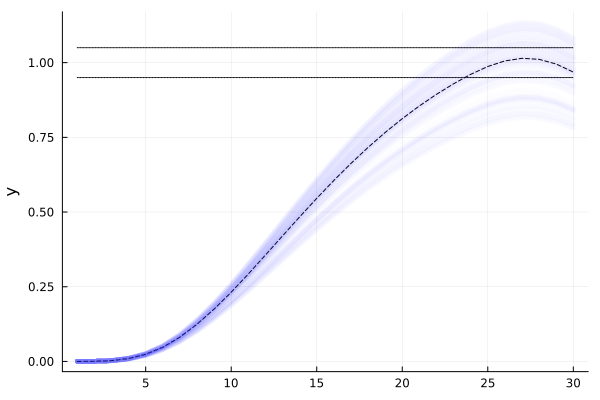

In [11]:
gr()

p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,yTraj,linestyle = :dash,linecolor = :black)

for jj = 1:nMC
    if jj == 1 # adding legend
        p1 = plot!(ts,yPlant_ol[:,jj],linewidth=5,yaxis="y",linecolor = :blue,linealpha = 0.01)
    else
        p1 = plot!(ts,yPlant_ol[:,jj],linewidth=5,yaxis="y",linecolor = :blue,linealpha = 0.01,legend=false)
    end
end
    
p1.series_list[1][:label] = "yt"
p1.series_list[2][:label] = ""
p1.series_list[3][:label] = "yTraj"
p1.series_list[4][:label] = "yol"

display(p1)

# Solving OL-DRTO Multiscenario Problem
Using mean value of B matrix

In [12]:
#number os scenarios
nScen = 3

#DRTO execution period
nDRTO = 5

#equiprobable scenarios
pScen = 1.0/nScen;

# uncertainty in B - each column represent a different realization
B_drto_s = [0.05 0.0625 0.07; 0 0 0; 0 0 0];

In [13]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_OLDRTO(xInit,uInit)

    # Define our model
    model_ms = Model(CPLEX.Optimizer)
    #set_optimizer_attribute(model_ms, "CPXPARAM_ScreenOutput"=false)
    # set_optimizer_attribute(m, "warm_start_init_point", "yes")

    # Set up variables
    # inputs computed by MPCs
    @variable(model_ms, uMin <= u[1:pD,1:nScen] <= uMax)
    # initial states used by MPC for computing the optimal trajectory
    @variable(model_ms, x[1:pD, 1:nx,1:nScen])
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, yMin <= y[1:pD,1:nScen] <= yMax)
    # slacks for controlling setpoint into a zone
    @variable(model_ms, delta_y_p[1:pD,1:nScen] >= 0)
    @variable(model_ms, delta_y_m[1:pD,1:nScen] >= 0)

    # Set up objective function
    @objective(model_ms, Min, pScen*sum(u[kk,ss] + 1e5*(delta_y_p[kk,ss]^2 + delta_y_m[kk,ss]^2) 
            for kk in 1:pD, ss in 1:nScen))

    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, OLDRTO_dyn_model_1[ss=1:nScen], x[1,:,ss] .== A_drto*xInit + B_drto_s[:,ss]*uInit)
    @constraint(model_ms, OLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], x[kk + 1,:,ss] .== A_drto*x[kk,:,ss] + B_drto_s[:,ss]*u[kk,ss])
    @constraint(model_ms, OLDRTO_model_out[kk=1:pD,ss=1:nScen], y[kk,ss] == C_drto'*x[kk,:,ss])

    # fixing input after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,ss] == u[mD,ss])

    # Δu constraints
    @constraint(model_ms, ΔU_max_0[ss=1:nScen], -ΔUMax <= u[1,ss] - uInit <= ΔUMax)
    @constraint(model_ms, ΔU[kk=2:mD,ss=1:nScen], -ΔUMax <= u[kk,ss] - u[kk - 1,ss] <= ΔUMax)

    # ysp in target
    @constraint(model_ms, target_plus[kk=1:pD,ss=1:nScen], y[kk,ss] + delta_y_p[kk,ss] >= 0.95)
    @constraint(model_ms, target_minus[kk=1:pD,ss=1:nScen], y[kk,ss] - delta_y_m[kk,ss] <= 1.05)

    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], u[kk,1] - u[kk,ss] == 0.0);
    
    # @show model_ms
    
    optimize!(model_ms)
    flag = termination_status(model_ms)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(model_ms)
    uArray = value.(u)
    xArray = value.(x)
    yArray = value.(y)
    dpArray = value.(delta_y_p)
    dmArray = value.(delta_y_m)
    
    # all_con = all_constraints(model_ms, AffExpr, MOI.EqualTo{Float64})
    λ = dual.(nonAnt)
    
    return Dict('o' => o, 'f' => flag, 'λ' => λ, 'u' => uArray, 'x' => xArray, 'y' => yArray, 'd' => dpArray, 'c' => dmArray)
end;

In [14]:
# Solve the model
solDict = MS_OLDRTO(x0,u0);

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.5705793e+06  -5.6570493e+06  1.53e+02  2.23e+02  1.10e+07
   1   2.8599542e+06  -2.7842258e+06  1.05e+02  1.53e+02  7.54e+06
   2   1.3737139e+06 

In [19]:
# Get values for plotting
xTraj_ms = Array{Float64}(undef,nx,pD,nScen)
uTraj_ms = Matrix{Float64}(undef,pD,nScen) 
yTraj_ms = Matrix{Float64}(undef,pD,nScen) 

for i in 1:pD
    for s in 1:nScen
        xTraj_ms[:,i,s] .= solDict['x'][i,:,s]
        yTraj_ms[i,s] = solDict['y'][i,s]
        uTraj_ms[i,s] = solDict['u'][i,s]
    end
end;

#display(solDict['u'][1,1])
#display(solDict['u'][1,2])
#display(solDict['u'][1,3])
display(xTraj_ms)

3×30×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.015  0.0668429  0.179015   …  8.88317  9.03528  9.16966  9.28805
 0.0  0.0    0.015      0.0668429     8.71151  8.88317  9.03528  9.16966
 0.0  0.0    0.0        0.015         8.51842  8.71151  8.88317  9.03528

[:, :, 2] =
 0.0  0.01875  0.0835536  0.223768   …  10.6371  10.4765  10.1949   9.81064
 0.0  0.0      0.01875    0.0835536     10.6656  10.6371  10.4765  10.1949
 0.0  0.0      0.0        0.01875       10.5645  10.6656  10.6371  10.4765

[:, :, 3] =
 0.0  0.021  0.09358  0.25062  …  10.6972  10.3938  10.0009   9.53348
 0.0  0.0    0.021    0.09358     10.9026  10.6972  10.3938  10.0009
 0.0  0.0    0.0      0.021       11.0129  10.9026  10.6972  10.3938

## Plotting results

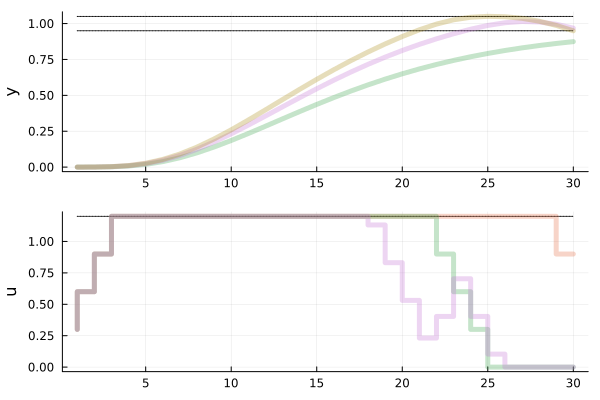

In [16]:
gr()

p3 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p3 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)

for ss = 1:nScen
    if ss == 1 # adding legend
        p3 = plot!(ts,yTraj_ms[:,ss],linewidth=5,yaxis="y",linealpha = 0.3)
    else
        p3 = plot!(ts,yTraj_ms[:,ss],linewidth=5,linealpha = 0.3,legend=false)
    end
end
    
p3.series_list[1][:label] = "yt"
p3.series_list[2][:label] = ""
p3.series_list[3][:label] = "y1"
p3.series_list[4][:label] = "y2"
p3.series_list[4][:label] = "y3"

p4 = plot(ts,1.2*ones(length(ts)),linestyle = :dot,linecolor = :black)
for ss = 1:nScen
    if ss == 1 # adding legend
        p4 = plot!(ts,uTraj_ms[:,ss],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3)
    else
        p4 = plot!(ts,uTraj_ms[:,ss],linewidth=5,linetype=:steppre,linealpha = 0.3,legend=false)
    end
end

g3 = plot(p3,p4,layout=(2,1))
display(g3)

# Simulating Plant Implementation of the Results

Similar to the previous section, we run a Monte Carlo Analysis of the DRTO results. But we run for a longer horizon using the multi-stage controller

In [17]:
# Monte Carlo iterations
nMC_imp = 20

# Simulation time in sampling periods
nsim = 100

# time series for plotting
xPlant_ol_ms = Array{Float64}(undef,nx,nsim,nMC_imp) 
uPlant_ol_ms = Matrix{Float64}(undef,nsim,nMC_imp) 
yPlant_ol_ms = Matrix{Float64}(undef,nsim,nMC_imp) 

for jj = 1:nMC_imp
    # Plant model
    Ap = A_drto
    Bp = [rand(Uniform(0.05,0.07));0;0] # drawing value from random uniform distribution
    Cp = C_drto;
    
    # initializing simulation
    xpk = x0 # plant
    uk = u0
    ypk = Cp'*x0

    # RUNNING SIMULATION
    for ii = 1:nsim
        
        print("MC: ", jj)
        println(">> Time: ",ii)

        # updating arrays
        xPlant_ol_ms[:,ii,jj] = xpk
        uPlant_ol_ms[ii,jj] = uk
        yPlant_ol_ms[ii,jj] = ypk
        
        # executing DRTO
        if ii%nDRTO == 0 || ii == 1
            global sol_k = MS_OLDRTO(xpk,uk)
            # counter for DRTO executions
            global countDRTO = 1;
            # N.B. need to declare as global due to loop scope
        end
        
         # extracting optimization results
        uk = sol_k['u'][countDRTO,1] # using arbitrary scenario = non-antecipativity constraints
        
        # applying input to the plant
        xpk = Ap*xpk + Bp*uk
        countDRTO += 1;
        
        ypk = Cp'*xpk 

    end
end

MC: 1>> Time: 1
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.5705793e+06  -5.6570493e+06  1.53e+02  2.23e+02  1.10e+07
   1   2.8599542e+06  -2.7842258e+06  1.05e+02  1.53e+02  7.54e+06
   2 

MC: 1>> Time: 26
MC: 1>> Time: 27
MC: 1>> Time: 28
MC: 1>> Time: 29
MC: 1>> Time: 30
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 52 rows and 53 columns.
Aggregator did 202 substitutions.
Reduced QP has 386 rows, 465 columns, and 1260 nonzeros.
Reduced QP objective Q matrix has 157 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1501
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 386
  Integer space required    = 622
  Total non-zeros in factor = 3454
  Total FP ops to factor    = 47158
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2333363e+08  -5.2359583e+08  3.08e+03  4.58e+03  1.05e+08
   

MC: 1>> Time: 66
MC: 1>> Time: 67
MC: 1>> Time: 68
MC: 1>> Time: 69
MC: 1>> Time: 70
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2000030e+08  -5.2026250e+08  3.08e+03  4.58e+03  1.04e+08
   

MC: 2>> Time: 1
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.5705793e+06  -5.6570493e+06  1.53e+02  2.23e+02  1.10e+07
   1   2.8599542e+06  -2.7842258e+06  1.05e+02  1.53e+02  7.54e+06
   2 

MC: 2>> Time: 31
MC: 2>> Time: 32
MC: 2>> Time: 33
MC: 2>> Time: 34
MC: 2>> Time: 35
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 50 rows and 51 columns.
Aggregator did 202 substitutions.
Reduced QP has 388 rows, 467 columns, and 1267 nonzeros.
Reduced QP objective Q matrix has 159 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1545
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 388
  Integer space required    = 624
  Total non-zeros in factor = 3507
  Total FP ops to factor    = 48563
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.3000030e+08  -5.3026250e+08  3.08e+03  4.58e+03  1.06e+08
   

MC: 2>> Time: 51
MC: 2>> Time: 52
MC: 2>> Time: 53
MC: 2>> Time: 54
MC: 2>> Time: 55
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 50 rows and 51 columns.
Aggregator did 202 substitutions.
Reduced QP has 388 rows, 467 columns, and 1267 nonzeros.
Reduced QP objective Q matrix has 159 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1545
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 388
  Integer space required    = 624
  Total non-zeros in factor = 3507
  Total FP ops to factor    = 48563
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.3000030e+08  -5.3026250e+08  3.08e+03  4.58e+03  1.06e+08
   

MC: 2>> Time: 91
MC: 2>> Time: 92
MC: 2>> Time: 93
MC: 2>> Time: 94
MC: 2>> Time: 95
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 50 rows and 51 columns.
Aggregator did 202 substitutions.
Reduced QP has 388 rows, 467 columns, and 1267 nonzeros.
Reduced QP objective Q matrix has 159 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1545
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 388
  Integer space required    = 624
  Total non-zeros in factor = 3507
  Total FP ops to factor    = 48563
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.3000030e+08  -5.3026250e+08  3.08e+03  4.58e+03  1.06e+08
   

MC: 3>> Time: 8
MC: 3>> Time: 9
MC: 3>> Time: 10
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.2266406e+08  -1.2284441e+08  1.41e+03  2.09e+03  5.12e+07
   1   1.7046240e+06  -1.7479986e+06  1

MC: 3>> Time: 34
MC: 3>> Time: 35
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.01 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2000030e+08  -5.2026250e+08  3.08e+03  4.58e+03  1.04e+08
   1   1.2990874e+06  -1.5409160e+06  1.45e+02  2.16e+

MC: 3>> Time: 53
MC: 3>> Time: 54
MC: 3>> Time: 55
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2000030e+08  -5.2026250e+08  3.08e+03  4.58e+03  1.04e+08
   1   1.3211827e+06  -1.5630406e+06 

MC: 3>> Time: 91
MC: 3>> Time: 92
MC: 3>> Time: 93
MC: 3>> Time: 94
MC: 3>> Time: 95
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2000030e+08  -5.2026250e+08  3.08e+03  4.58e+03  1.04e+08
   

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.4326947e+08  -1.4345733e+08  1.54e+03  2.28e+03  5.53e+07
   1   1.5691382e+06  -1.6345674e+06  1.49e+02  2.20e+02  5.35e+06
   2   9.4278296e+05 

MC: 4>> Time: 31
MC: 4>> Time: 32
MC: 4>> Time: 33
MC: 4>> Time: 34
MC: 4>> Time: 35
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 51 rows and 52 columns.
Aggregator did 202 substitutions.
Reduced QP has 387 rows, 466 columns, and 1264 nonzeros.
Reduced QP objective Q matrix has 158 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1524
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 387
  Integer space required    = 623
  Total non-zeros in factor = 3480
  Total FP ops to factor    = 47834
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2666697e+08  -5.2692917e+08  3.08e+03  4.58e+03  1.05e+08
   

MC: 4>> Time: 57
MC: 4>> Time: 58
MC: 4>> Time: 59
MC: 4>> Time: 60
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 49 rows and 49 columns.
Aggregator did 202 substitutions.
Reduced QP has 389 rows, 469 columns, and 1271 nonzeros.
Reduced QP objective Q matrix has 158 nonzeros.
Presolve time = 0.00 sec. (0.54 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1567
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 389
  Integer space required    = 625
  Total non-zeros in factor = 3535
  Total FP ops to factor    = 49347
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2666697e+08  -5.2693097e+08  3.10e+03  4.64e+03  1.05e+08
   1   6.9642476e+05

MC: 4>> Time: 96
MC: 4>> Time: 97
MC: 4>> Time: 98
MC: 4>> Time: 99
MC: 4>> Time: 100
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 49 rows and 49 columns.
Aggregator did 202 substitutions.
Reduced QP has 389 rows, 469 columns, and 1271 nonzeros.
Reduced QP objective Q matrix has 158 nonzeros.
Presolve time = 0.00 sec. (0.54 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1567
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 389
  Integer space required    = 625
  Total non-zeros in factor = 3535
  Total FP ops to factor    = 49347
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.2666697e+08  -5.2693097e+08  3.10e+03  4.64e+03  1.05e+08
  

MC: 5>> Time: 16
MC: 5>> Time: 17
MC: 5>> Time: 18
MC: 5>> Time: 19
MC: 5>> Time: 20
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0452123e+08  -3.0478448e+08  2.33e+03  3.45e+03  8.04e+07
   

MC: 5>> Time: 41
MC: 5>> Time: 42
MC: 5>> Time: 43
MC: 5>> Time: 44
MC: 5>> Time: 45
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.2360999e+08  -3.2387225e+08  2.39e+03  3.56e+03  8.20e+07
   

MC: 5>> Time: 61
MC: 5>> Time: 62
MC: 5>> Time: 63
MC: 5>> Time: 64
MC: 5>> Time: 65
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.2351086e+08  -3.2377313e+08  2.39e+03  3.56e+03  8.20e+07
   

MC: 6>> Time: 1
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.5705793e+06  -5.6570493e+06  1.53e+02  2.23e+02  1.10e+07
   1   2.8599542e+06  -2.7842258e+06  1.05e+02  1.53e+02  7.54e+06
   2 

MC: 6>> Time: 21
MC: 6>> Time: 22
MC: 6>> Time: 23
MC: 6>> Time: 24
MC: 6>> Time: 25
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.9329247e+08  -2.9355791e+08  2.29e+03  3.38e+03  7.89e+07
   

MC: 6>> Time: 46
MC: 6>> Time: 47
MC: 6>> Time: 48
MC: 6>> Time: 49
MC: 6>> Time: 50
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0033959e+08  -3.0060186e+08  2.30e+03  3.42e+03  7.90e+07
   

MC: 6>> Time: 76
MC: 6>> Time: 77
MC: 6>> Time: 78
MC: 6>> Time: 79
MC: 6>> Time: 80
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0033347e+08  -3.0059574e+08  2.30e+03  3.42e+03  7.90e+07
   

MC: 7>> Time: 1
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   5.5705793e+06  -5.6570493e+06  1.53e+02  2.23e+02  1.10e+07
   1   2.8599542e+06  -2.7842258e+06  1.05e+02  1.53e+02  7.54e+06
   2 

MC: 7>> Time: 29
MC: 7>> Time: 30
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.9307532e+08  -2.9334170e+08  2.29e+03  3.38e+03  7.89e+07
   1   6.2962586e+05  -8.6294512e+05  9.71e+01  1.43e+

MC: 7>> Time: 52
MC: 7>> Time: 53
MC: 7>> Time: 54
MC: 7>> Time: 55
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 50 rows and 50 columns.
Aggregator did 202 substitutions.
Reduced QP has 388 rows, 468 columns, and 1267 nonzeros.
Reduced QP objective Q matrix has 157 nonzeros.
Presolve time = 0.00 sec. (0.54 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1542
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 388
  Integer space required    = 624
  Total non-zeros in factor = 3507
  Total FP ops to factor    = 48563
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.3056491e+08  -2.3082903e+08  2.00e+03  2.99e+03  6.95e+07
   1   6.0057171e+05

MC: 7>> Time: 71
MC: 7>> Time: 72
MC: 7>> Time: 73
MC: 7>> Time: 74
MC: 7>> Time: 75
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 50 rows and 50 columns.
Aggregator did 202 substitutions.
Reduced QP has 388 rows, 468 columns, and 1267 nonzeros.
Reduced QP objective Q matrix has 157 nonzeros.
Presolve time = 0.00 sec. (0.54 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1542
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 388
  Integer space required    = 624
  Total non-zeros in factor = 3507
  Total FP ops to factor    = 48563
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.3066676e+08  -2.3093088e+08  2.00e+03  2.99e+03  6.95e+07
   

MC: 7>> Time: 91
MC: 7>> Time: 92
MC: 7>> Time: 93
MC: 7>> Time: 94
MC: 7>> Time: 95
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 50 rows and 50 columns.
Aggregator did 202 substitutions.
Reduced QP has 388 rows, 468 columns, and 1267 nonzeros.
Reduced QP objective Q matrix has 157 nonzeros.
Presolve time = 0.00 sec. (0.54 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1542
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 388
  Integer space required    = 624
  Total non-zeros in factor = 3507
  Total FP ops to factor    = 48563
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.3079653e+08  -2.3106065e+08  2.00e+03  2.99e+03  6.95e+07
   

MC: 8>> Time: 26
MC: 8>> Time: 27
MC: 8>> Time: 28
MC: 8>> Time: 29
MC: 8>> Time: 30
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 51 rows and 51 columns.
Aggregator did 202 substitutions.
Reduced QP has 387 rows, 467 columns, and 1263 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.54 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1518
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 387
  Integer space required    = 623
  Total non-zeros in factor = 3480
  Total FP ops to factor    = 47834
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   2.2233658e+08  -2.2260098e+08  1.97e+03  2.94e+03  6.80e+07
   

MC: 8>> Time: 46
MC: 8>> Time: 47
MC: 8>> Time: 48
MC: 8>> Time: 49
MC: 8>> Time: 50
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0443673e+08  -3.0469900e+08  2.32e+03  3.44e+03  7.96e+07
   

MC: 8>> Time: 66
MC: 8>> Time: 67
MC: 8>> Time: 68
MC: 8>> Time: 69
MC: 8>> Time: 70
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.02 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0435596e+08  -3.0461823e+08  2.32e+03  3.44e+03  7.96e+07
   

MC: 8>> Time: 87
MC: 8>> Time: 88
MC: 8>> Time: 89
MC: 8>> Time: 90
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0435612e+08  -3.0461838e+08  2.32e+03  3.44e+03  7.96e+07
   1   6.2318563e+05

MC: 9>> Time: 14
MC: 9>> Time: 15
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   1.9670362e+08  -1.9693695e+08  1.84e+03  2.72e+03  6.47e+07
   1   7.5011566e+05  -9.0949499e+05  1.03e+02  1.52e+

MC: 9>> Time: 46
MC: 9>> Time: 47
MC: 9>> Time: 48
MC: 9>> Time: 49
MC: 9>> Time: 50
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.02 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0813829e+08  -3.0840056e+08  2.33e+03  3.46e+03  8.01e+07
   

MC: 9>> Time: 66
MC: 9>> Time: 67
MC: 9>> Time: 68
MC: 9>> Time: 69
MC: 9>> Time: 70
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0797183e+08  -3.0823410e+08  2.33e+03  3.46e+03  8.00e+07
   

MC: 9>> Time: 91
MC: 9>> Time: 92
MC: 9>> Time: 93
MC: 9>> Time: 94
MC: 9>> Time: 95
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0797200e+08  -3.0823426e+08  2.33e+03  3.46e+03  8.00e+07
   

MC: 10>> Time: 8
MC: 10>> Time: 9
MC: 10>> Time: 10
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 41 rows and 42 columns.
Aggregator did 202 substitutions.
Reduced QP has 397 rows, 476 columns, and 1289 nonzeros.
Reduced QP objective Q matrix has 165 nonzeros.
Presolve time = 0.00 sec. (0.56 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1689
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.15 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 397
  Integer space required    = 636
  Total non-zeros in factor = 3696
  Total FP ops to factor    = 54174
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   9.8702956e+07  -9.8873226e+07  1.25e+03  1.85e+03  4.60e+07
   1   1.9877866e+06  -2.0021491e+06

MC: 10>> Time: 37
MC: 10>> Time: 38
MC: 10>> Time: 39
MC: 10>> Time: 40
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0518957e+08  -3.0545184e+08  2.32e+03  3.45e+03  7.97e+07
   1   6.2330874

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0346054e+08  -3.0372281e+08  2.31e+03  3.43e+03  7.94e+07
   1   6.2248509e+05  -8.5489733e+05  9.60e+01  1.43e+02  3.30e+06
   2   7.4048468e+04 

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 53 rows and 54 columns.
Aggregator did 202 substitutions.
Reduced QP has 385 rows, 464 columns, and 1256 nonzeros.
Reduced QP objective Q matrix has 156 nonzeros.
Presolve time = 0.00 sec. (0.55 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1479
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.14 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 385
  Integer space required    = 621
  Total non-zeros in factor = 3429
  Total FP ops to factor    = 46533
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   3.0346077e+08  -3.0372304e+08  2.31e+03  3.43e+03  7.94e+07
   1   6.2246430e+05  -8.5487653e+05  9.60e+01  1.43e+02  3.30e+06
   2   6.9734442e+04 

Excessive output truncated after 526409 bytes.


MC: 10>> Time: 95

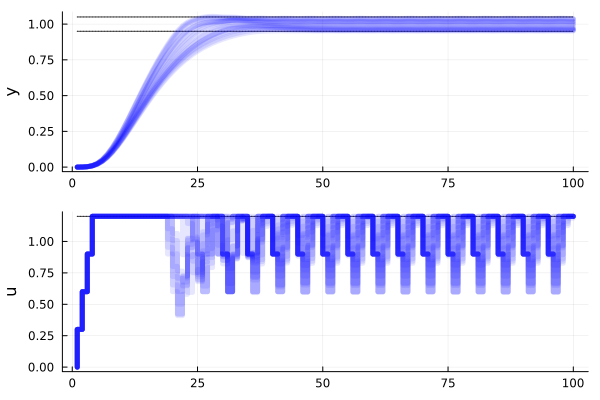

In [18]:
gr()

# time series for plotting
ts_ol = Vector{Float64}(undef,nsim) 
for ii in 1:nsim
    ts_ol[ii] = 1*ii
end

p5 = plot(ts_ol,1.05*ones(length(ts_ol)),linestyle = :dot,linecolor = :black)
p5 = plot!(ts_ol,0.95*ones(length(ts_ol)),linestyle = :dot,linecolor = :black,legend=false)

for jj = 1:nMC_imp
    if jj == 1 # adding legend
        p5 = plot!(ts_ol,yPlant_ol_ms[:,jj],linewidth=5,yaxis="y",linecolor = :blue,linealpha = 0.1)
    else
        p5 = plot!(ts_ol,yPlant_ol_ms[:,jj],linewidth=5,yaxis="y",linecolor = :blue,linealpha = 0.1,legend=false)
    end
end
    
p5.series_list[1][:label] = "ytarg"
p5.series_list[2][:label] = "y"

p6 = plot(ts_ol,1.2*ones(length(ts_ol)),linestyle = :dot,linecolor = :black)
for jj = 1:nMC_imp
    p6 = plot!(ts_ol,uPlant_ol_ms[:,jj],linewidth=5,yaxis="u",linecolor = :blue,linetype=:steppre,linealpha = 0.1,legend=false)
end

g4 = plot(p5,p6,layout=(2,1))
display(g4)
